In [1]:
import requests
import pandas as pd
pd.set_option('display.max_colwidth',200)
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve
from collections import Counter
from sklearn.metrics import roc_auc_score

plt.style.use('fivethirtyeight')
%matplotlib inline

# Data Importing

In [2]:
# Loading Investing dataset

invest = pd.read_csv('investing.csv', usecols = ['subreddit','title','selftext'])\
[['subreddit','title','selftext']]

In [3]:
#Check how the dataframe looks like
invest 

,subreddit,title,selftext
0,investing,Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE**,"Alright everyone, it looks like we had pretty broad support in [this thread](https://www.reddit.com/r/investing/comments/cuuo6j/yooo_get_in_here_peeps_state_of_the_subreddit/) when it comes to cra..."
1,investing,Daily Advice Thread - All basic help or advice questions must be posted here.,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are going to ask how to invest you should include relevant information, such as th..."
2,investing,How did r/investing become so low quality?,"The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get tired of it?\n\nThere are plenty of factors..."
3,investing,Unpopular Opinion: The crazy run on stocks right now actually makes sense,"I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manageable mortgage and just want to grow my nest egg, so I invest ~40% of it. \..."
4,investing,Apple is on track to have the single greatest one-day market cap loss of all time,"Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billion. The largest market cap daily loss ever was [Facebook losing $119 billion after..."
...,...,...,...
1214,investing,How is stock dilution not illegal?,Can you really simply decrease the share that your shareholders own by issuing new equity? Shouldn't you instead just sell equity that hasn't been publicly owned yet? Or where else is the equity c...
1215,investing,LinusTechTips' Analysis on Corsair IPO,"https://youtu.be/kDYok0dEauo\n\nAt the 54:11 mark\n\nAside from the SEC filing, Linus provides some perspective as someone who is very well-versed with Corsair\n\nPros\nDominant position in the in..."
1216,investing,2 Stocks and a Breakdown,"**Sentiments for the fall**\n\n On going political and social issues around the globe, and the underlying fear behind Covid-19 still stifling economies are just some of the problems investors are..."
1217,investing,Can someone help with debt to equity ration with airbus?,I get financial statemets from here [https://www.airbus.com/investors/financial-results-and-annual-reports.html](https://www.airbus.com/investors/financial-results-and-annual-reports.html) and i...


In [4]:
#Load Trading dataset

trade = pd.read_csv('trading.csv', usecols = ['subreddit','title','selftext'])\
[['subreddit','title','selftext']]

In [5]:
trade

,subreddit,title,selftext
0,Trading,TPII: Triad Pro Innovators. One to watch,"185k avg daily volume, up this week. $0.02/share, 16m float off 47m total, low market cap. News incoming, DS GT players will see the similarities soon. Lots of room to jump here. Good charts. Insi..."
1,Trading,Analysis Paralysis - When Retail Traders are Overly Bullish,\n\nIt's common for writers to scream *Bear!* using all sorts of fancy technical analysis and be wrong for months on end only to re-write their article and cry wolf again until eventually they ar...
2,Trading,How do you guys see Stock of Tesla in the future?,NaN
3,Trading,Are my elliot waves drawn correctly?,[https://www.tradingview.com/x/6MTkcujb/](https://www.tradingview.com/x/6MTkcujb/)
4,Trading,investing in myself,hi there! i recently got interested in trading and i am about to open an account with a broker. now i know that there are books and videos out there explaining how things work and what to look for...
...,...,...,...
1211,Trading,I am 17 and want to learn to invest/trade.,I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advice please comment below.
1212,Trading,A scammer has been contacting r/Trading members to try to part them with their Crypto.,I called him out on one of his comments and another Reddit user who had been recently contact by him messaged me to ask me what happened. \n\nSee chat log: https://imgur.com/gallery/eHYpZR2
1213,Trading,Trading,How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\nFor exam...
1214,Trading,Horizontal Channel? Fib retracement?,I'm a trading newb. I really just like to jump in during times of high uncertainty with a couple hundred bucks to see what I can do. I treat it like very informed horse race betting...\n\nAlso a n...


# Data Cleaning

Steps in this order

- Check for duplicates
- Drop duplicates
- Concatenate Investing and Trading dataset
- Reset index
- Make new column 'total' which combines title and selftext values
- check for isnull
- drop isnull values
- map/classify subrredit, investing as 0 , trading is 1 for classification prediction model 
- Function to clean posts, 


In [6]:
# Select duplicate rows except first occurrence based on all columns
duplicaterows = invest[invest.duplicated(['title','selftext'])]
print("Duplicate Rows except first occurrence based on all columns are :",len(duplicaterows))


Duplicate Rows except first occurrence based on all columns are : 694


In [7]:
duplicaterows2 = trade[trade.duplicated(['title','selftext'])]
print("Duplicate Rows except first occurrence based on all columns are :",len(duplicaterows2))

Duplicate Rows except first occurrence based on all columns are : 609


In [8]:
invest.drop_duplicates(subset = ['title','selftext'],keep = 'first', inplace = True)

In [9]:

invest

,subreddit,title,selftext
0,investing,Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE**,"Alright everyone, it looks like we had pretty broad support in [this thread](https://www.reddit.com/r/investing/comments/cuuo6j/yooo_get_in_here_peeps_state_of_the_subreddit/) when it comes to cra..."
1,investing,Daily Advice Thread - All basic help or advice questions must be posted here.,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are going to ask how to invest you should include relevant information, such as th..."
2,investing,How did r/investing become so low quality?,"The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get tired of it?\n\nThere are plenty of factors..."
3,investing,Unpopular Opinion: The crazy run on stocks right now actually makes sense,"I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manageable mortgage and just want to grow my nest egg, so I invest ~40% of it. \..."
4,investing,Apple is on track to have the single greatest one-day market cap loss of all time,"Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billion. The largest market cap daily loss ever was [Facebook losing $119 billion after..."
...,...,...,...
530,investing,$GNUS | Genius Brands Intl.,Out of curiosity from its recent spikes from May-August; I spent the last 3 weeks gathering information on this company to see if I can understand its value. I now have reason to believe it will m...
531,investing,Can you short parking?,"In my city you can either rent parking for about £100 a month, or buy a parking space for about £20k, so parking has a p/e of about 17. I imagine the global value of parking spaces is multiple bil..."
532,investing,Question about Unemployment while having an LLC,\nI have just set up a LLC as a tax strategy for my weekly trading/investing income. I’m currently receiving unemployment since my work has reduced my hours to 0 because of Covid. \nDoes now havin...
533,investing,Full sector breakdown tool for etfs?,"Does anyone know of an online tool that will show a full sector breakdown of an ETF, down to the final level of GICS called sub-industry?\n\nThere is this overlap tool [https://www.etfrc.com/funds..."


In [10]:
trade.drop_duplicates(subset = ['title','selftext'],keep = 'first', inplace = True)

In [11]:
trade

,subreddit,title,selftext
0,Trading,TPII: Triad Pro Innovators. One to watch,"185k avg daily volume, up this week. $0.02/share, 16m float off 47m total, low market cap. News incoming, DS GT players will see the similarities soon. Lots of room to jump here. Good charts. Insi..."
1,Trading,Analysis Paralysis - When Retail Traders are Overly Bullish,\n\nIt's common for writers to scream *Bear!* using all sorts of fancy technical analysis and be wrong for months on end only to re-write their article and cry wolf again until eventually they ar...
2,Trading,How do you guys see Stock of Tesla in the future?,NaN
3,Trading,Are my elliot waves drawn correctly?,[https://www.tradingview.com/x/6MTkcujb/](https://www.tradingview.com/x/6MTkcujb/)
4,Trading,investing in myself,hi there! i recently got interested in trading and i am about to open an account with a broker. now i know that there are books and videos out there explaining how things work and what to look for...
...,...,...,...
603,Trading,I am 17 and want to learn to invest/trade.,I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advice please comment below.
604,Trading,A scammer has been contacting r/Trading members to try to part them with their Crypto.,I called him out on one of his comments and another Reddit user who had been recently contact by him messaged me to ask me what happened. \n\nSee chat log: https://imgur.com/gallery/eHYpZR2
605,Trading,Trading,How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\nFor exam...
606,Trading,Horizontal Channel? Fib retracement?,I'm a trading newb. I really just like to jump in during times of high uncertainty with a couple hundred bucks to see what I can do. I treat it like very informed horse race betting...\n\nAlso a n...


In [12]:
df1 = pd.concat([invest,trade],axis=0)


In [13]:
df1.shape

(1132, 3)

In [14]:
df1.reset_index(drop=True,inplace=True)

In [15]:
df1

,subreddit,title,selftext
0,investing,Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE**,"Alright everyone, it looks like we had pretty broad support in [this thread](https://www.reddit.com/r/investing/comments/cuuo6j/yooo_get_in_here_peeps_state_of_the_subreddit/) when it comes to cra..."
1,investing,Daily Advice Thread - All basic help or advice questions must be posted here.,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are going to ask how to invest you should include relevant information, such as th..."
2,investing,How did r/investing become so low quality?,"The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get tired of it?\n\nThere are plenty of factors..."
3,investing,Unpopular Opinion: The crazy run on stocks right now actually makes sense,"I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manageable mortgage and just want to grow my nest egg, so I invest ~40% of it. \..."
4,investing,Apple is on track to have the single greatest one-day market cap loss of all time,"Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billion. The largest market cap daily loss ever was [Facebook losing $119 billion after..."
...,...,...,...
1127,Trading,I am 17 and want to learn to invest/trade.,I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advice please comment below.
1128,Trading,A scammer has been contacting r/Trading members to try to part them with their Crypto.,I called him out on one of his comments and another Reddit user who had been recently contact by him messaged me to ask me what happened. \n\nSee chat log: https://imgur.com/gallery/eHYpZR2
1129,Trading,Trading,How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\nFor exam...
1130,Trading,Horizontal Channel? Fib retracement?,I'm a trading newb. I really just like to jump in during times of high uncertainty with a couple hundred bucks to see what I can do. I treat it like very informed horse race betting...\n\nAlso a n...


In [16]:
df1['total'] = df1['title'] + " " + df1['selftext']

In [17]:
df1

,subreddit,title,selftext,total
0,investing,Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE**,"Alright everyone, it looks like we had pretty broad support in [this thread](https://www.reddit.com/r/investing/comments/cuuo6j/yooo_get_in_here_peeps_state_of_the_subreddit/) when it comes to cra...","Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE** Alright everyone, it looks like we had pretty broad ..."
1,investing,Daily Advice Thread - All basic help or advice questions must be posted here.,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are going to ask how to invest you should include relevant information, such as th...","Daily Advice Thread - All basic help or advice questions must be posted here. If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are ..."
2,investing,How did r/investing become so low quality?,"The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get tired of it?\n\nThere are plenty of factors...","How did r/investing become so low quality? The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get ..."
3,investing,Unpopular Opinion: The crazy run on stocks right now actually makes sense,"I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manageable mortgage and just want to grow my nest egg, so I invest ~40% of it. \...",Unpopular Opinion: The crazy run on stocks right now actually makes sense I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manage...
4,investing,Apple is on track to have the single greatest one-day market cap loss of all time,"Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billion. The largest market cap daily loss ever was [Facebook losing $119 billion after...","Apple is on track to have the single greatest one-day market cap loss of all time Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billi..."
...,...,...,...,...
1127,Trading,I am 17 and want to learn to invest/trade.,I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advice please comment below.,I am 17 and want to learn to invest/trade. I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advi...
1128,Trading,A scammer has been contacting r/Trading members to try to part them with their Crypto.,I called him out on one of his comments and another Reddit user who had been recently contact by him messaged me to ask me what happened. \n\nSee chat log: https://imgur.com/gallery/eHYpZR2,A scammer has been contacting r/Trading members to try to part them with their Crypto. I called him out on one of his comments and another Reddit user who had been recently contact by him messaged...
1129,Trading,Trading,How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\nFor exam...,Trading How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\n...
1130,Trading,Horizontal Channel? Fib retracement?,I'm a trading newb. I really just like to 

In [18]:
df1.isnull().sum()

subreddit     0
title         0
selftext     47
total        47
dtype: int64

In [19]:
df1.dropna(inplace=True)

In [20]:
df1

,subreddit,title,selftext,total
0,investing,Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE**,"Alright everyone, it looks like we had pretty broad support in [this thread](https://www.reddit.com/r/investing/comments/cuuo6j/yooo_get_in_here_peeps_state_of_the_subreddit/) when it comes to cra...","Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE** Alright everyone, it looks like we had pretty broad ..."
1,investing,Daily Advice Thread - All basic help or advice questions must be posted here.,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are going to ask how to invest you should include relevant information, such as th...","Daily Advice Thread - All basic help or advice questions must be posted here. If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are ..."
2,investing,How did r/investing become so low quality?,"The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get tired of it?\n\nThere are plenty of factors...","How did r/investing become so low quality? The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get ..."
3,investing,Unpopular Opinion: The crazy run on stocks right now actually makes sense,"I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manageable mortgage and just want to grow my nest egg, so I invest ~40% of it. \...",Unpopular Opinion: The crazy run on stocks right now actually makes sense I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manage...
4,investing,Apple is on track to have the single greatest one-day market cap loss of all time,"Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billion. The largest market cap daily loss ever was [Facebook losing $119 billion after...","Apple is on track to have the single greatest one-day market cap loss of all time Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billi..."
...,...,...,...,...
1127,Trading,I am 17 and want to learn to invest/trade.,I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advice please comment below.,I am 17 and want to learn to invest/trade. I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advi...
1128,Trading,A scammer has been contacting r/Trading members to try to part them with their Crypto.,I called him out on one of his comments and another Reddit user who had been recently contact by him messaged me to ask me what happened. \n\nSee chat log: https://imgur.com/gallery/eHYpZR2,A scammer has been contacting r/Trading members to try to part them with their Crypto. I called him out on one of his comments and another Reddit user who had been recently contact by him messaged...
1129,Trading,Trading,How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\nFor exam...,Trading How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\n...
1130,Trading,Horizontal Channel? Fib retracement?,I'm a trading newb. I really just like to 

In [21]:
df1['class'] = df1['subreddit'].map({'investing':0,'Trading':1})

In [22]:
df1

,subreddit,title,selftext,total,class
0,investing,Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE**,"Alright everyone, it looks like we had pretty broad support in [this thread](https://www.reddit.com/r/investing/comments/cuuo6j/yooo_get_in_here_peeps_state_of_the_subreddit/) when it comes to cra...","Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE** Alright everyone, it looks like we had pretty broad ...",0
1,investing,Daily Advice Thread - All basic help or advice questions must be posted here.,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are going to ask how to invest you should include relevant information, such as th...","Daily Advice Thread - All basic help or advice questions must be posted here. If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are ...",0
2,investing,How did r/investing become so low quality?,"The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get tired of it?\n\nThere are plenty of factors...","How did r/investing become so low quality? The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get ...",0
3,investing,Unpopular Opinion: The crazy run on stocks right now actually makes sense,"I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manageable mortgage and just want to grow my nest egg, so I invest ~40% of it. \...",Unpopular Opinion: The crazy run on stocks right now actually makes sense I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manage...,0
4,investing,Apple is on track to have the single greatest one-day market cap loss of all time,"Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billion. The largest market cap daily loss ever was [Facebook losing $119 billion after...","Apple is on track to have the single greatest one-day market cap loss of all time Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billi...",0
...,...,...,...,...,...
1127,Trading,I am 17 and want to learn to invest/trade.,I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advice please comment below.,I am 17 and want to learn to invest/trade. I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advi...,1
1128,Trading,A scammer has been contacting r/Trading members to try to part them with their Crypto.,I called him out on one of his comments and another Reddit user who had been recently contact by him messaged me to ask me what happened. \n\nSee chat log: https://imgur.com/gallery/eHYpZR2,A scammer has been contacting r/Trading members to try to part them with their Crypto. I called him out on one of his comments and another Reddit user who had been recently contact by him messaged...,1
1129,Trading,Trading,How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\nFor exam...,Trading How's it guys\nI am new to trading and am very interested in learning as much as I can.\nThe reason I'm asking for help is because I do not really understand all the principles fully. \n\n...,1
1130,Trading,Horizontal Channel? Fib retracement?,I'm a trading ne

## Clean post function explained

Below function what it does is 
- In a sentence, in this order
- removes htmls, 
- anything that is not alphabet replace as spaces
- convert to lower case , then anything in a sentence is break up as a word 
- place stopwords, then reverse it out, i.e. only ensuring words chosen are not stopwords
- stem the words, stemming means trying to bring back the word to the base family, i.e. adjustable to adjust
- connect back the spaces from point 2 

In [23]:
def clean_posts(raw_post):
    """
    Function to convert a raw post to a string of words that have been cleaned. 
    - HTML, non-letters will be removed
    - words will be converted to lowercase
    - stopwords will be removed 
    - words will be stemmed to their root words
    
    The input is a single string, and 
    the output is a single string 
    
    """
    
    # Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
       
    
    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # Stemming 
    p_stemmer = PorterStemmer()
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]
    
    # Join the words back into one string separated by space, 
    # and return the result.
    
    
    return(" ".join(meaningful_words))

In [24]:
# Initialize an empty list to hold the clean posts
final_posts = []

# Instantiate counter.
j = 0

# For every review in our combined dataframe
for x in df1['total']:
    
    # Apply the function that we created earlier to clean the posts
    final_posts.append(clean_posts(x))
    
    j += 1

print("Completed")

Completed


Make new column 'final_posts' in df1 

In [25]:
df1['final_posts'] = final_posts

In [26]:
df1

,subreddit,title,selftext,total,class,final_posts
0,investing,Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE**,"Alright everyone, it looks like we had pretty broad support in [this thread](https://www.reddit.com/r/investing/comments/cuuo6j/yooo_get_in_here_peeps_state_of_the_subreddit/) when it comes to cra...","Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE** Alright everyone, it looks like we had pretty broad ...",0,formal post guidelin polit topic constitut invest vs corpor news read comment sub pleas alright everyon look like pretti broad support thread http www reddit com r invest comment cuuo j yooo get p...
1,investing,Daily Advice Thread - All basic help or advice questions must be posted here.,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are going to ask how to invest you should include relevant information, such as th...","Daily Advice Thread - All basic help or advice questions must be posted here. If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" questions. If you are ...",0,daili advic thread basic help advic question must post question advic person situat question go ask invest includ relev inform follow old employ make incom much object money buy hous retir save ri...
2,investing,How did r/investing become so low quality?,"The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get tired of it?\n\nThere are plenty of factors...","How did r/investing become so low quality? The top ~5 comments in every other thread are just low-effort ""jokes"" about market always going up or stocks not equal the economy.\n\nDo people not get ...",0,r invest becom low qualiti top comment everi thread low effort joke market alway go stock equal economi peopl get tire plenti factor could contribut bull market fear inflat grow number retail inve...
3,investing,Unpopular Opinion: The crazy run on stocks right now actually makes sense,"I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manageable mortgage and just want to grow my nest egg, so I invest ~40% of it. \...",Unpopular Opinion: The crazy run on stocks right now actually makes sense I currently have a good chunk of money that I want to invest to hedge against inflation. I have a downpayment and a manage...,0,unpopular opinion crazi run stock right actual make sens current good chunk money want invest hedg inflat downpay manag mortgag want grow nest egg invest rental properti like vacat due coronaviru ...
4,investing,Apple is on track to have the single greatest one-day market cap loss of all time,"Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billion. The largest market cap daily loss ever was [Facebook losing $119 billion after...","Apple is on track to have the single greatest one-day market cap loss of all time Apple is currently down $7.43 a share today and has 17.1 billion shares outstanding, which is a loss of $127 billi...",0,appl track singl greatest one day market cap loss time appl current share today billion share outstand loss billion largest market cap daili loss ever facebook lose billion disastr earn juli http ...
...,...,...,...,...,...,...
1127,Trading,I am 17 and want to learn to invest/trade.,I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for reading this if you have any advice please comment below.,I am 17 and want to learn to invest/trade. I know nothing about trading/investing but would like to learn how to do this and how to make money from it. Thanks for read

In [27]:
df1['wordcount'] = df1['final_posts'].apply(lambda x: len(str(x).split()))

# Exploratory Data Analysis

- Word Cloud
- Word Count
- Barplots of Word Count w.r.t CountVectorizer @ Investing + Trading posts
- Barplots of Word Count w.r.t CountVectorizer @ Investing posts 
- Barplots of Word Count w.r.t CountVectorizer @ Trading posts
- Barplots of Word Count w.r.t TF-IDF @ Investing posts
- Barplots of Word Count w.r.t TF-IDF @ Trading posts

In [28]:
# Write a function to plot a wordcloud for each subreddit

def plot_wordcloud(df,colname,coltype,groupby, title):
    text = df[df[colname]==coltype][groupby].values # Clean text that we want to wordcloud
    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=200,
                          colormap='Set2',
                         stopwords=STOPWORDS).generate(str(text))
    plt.figure(figsize=(12,10))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Removes the axis

## Word Cloud
#### Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. 

## Investing Word Cloud
- Invest, Stock, market, etf, compani, good, investor, share
- These are the words that strike a reader at first glance and would indicate to readers at first glance what Investing subreddit is mostly about, as these words appear frequently in Investing subreddit 



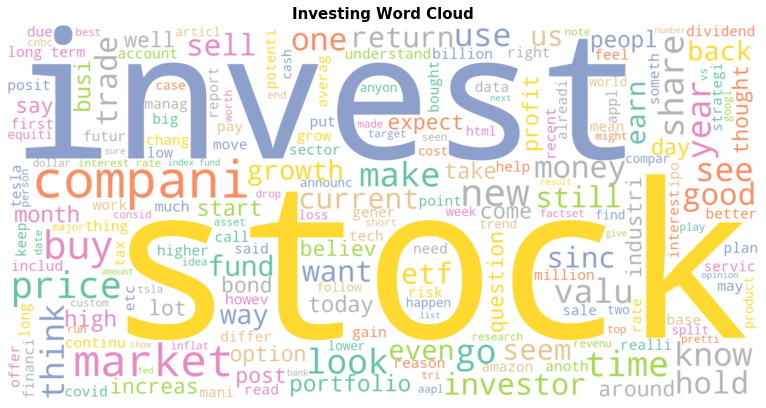

In [29]:
plot_wordcloud(df1,'subreddit','investing','final_posts','Investing Word Cloud')

## Trading Word Cloud 
- Trade, price, stock , buy , use , profit, time, make , look , market
- These words will strike a reader at first glance and would indicate to readers at first glance what Trading subreddit is mostly about, as these words appear frequently in the Trading subreddit 

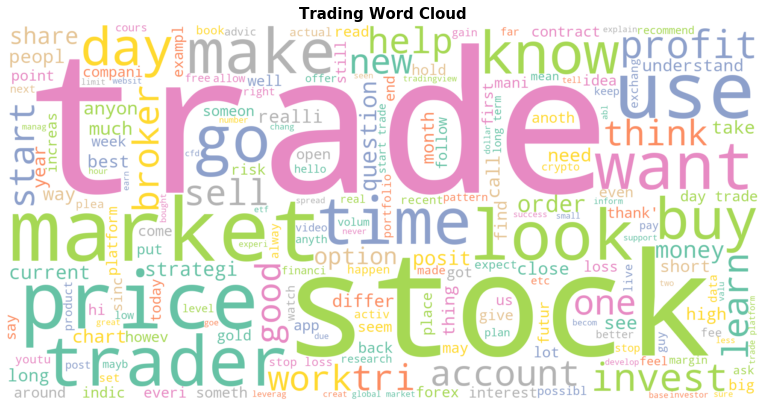

In [30]:
plot_wordcloud(df1,'subreddit','Trading','final_posts','Trading Word Cloud')

## Barplots of Word Count w.r.t CountVectorizer @ Investing + Trading posts

The top 20 words are mostly financial-related except words such as, like, http, com, use, know, look, want 

words like http, com, seems to be words that are broken up from hyperlinks, and it should be cleaned up. 

- Further cleaning of stop words
    - If this is present in both subreddits, will have to remove them, but will need to look whether it is present in Investing and Trading 

- Function to plot bar chart and different vectorizer
    - Will write a function to plot each subreddit, and also explore using TF-IDF as it zeroes out words/features that are commonly presently in a corpus, which will flagg out the more significant words

Text(0.5, 0.98, 'CountVectorizer')

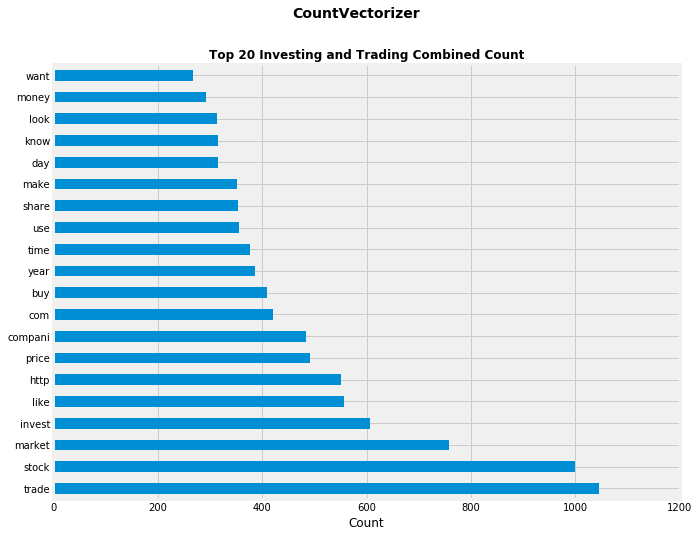

In [31]:
cvec = CountVectorizer(stop_words='english')
totaldf = df1['final_posts']
totaldf = cvec.fit_transform(totaldf)
totaldf = pd.DataFrame(totaldf.toarray(),columns=cvec.get_feature_names())
sum_words = totaldf.sum(axis=0)

sum_words.sort_values(ascending=False).head(20).plot(kind='barh',figsize=(10,8))
plt.title("Top 20 Investing and Trading Combined Count", fontsize=12, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.xlim(0,1200)
plt.suptitle('CountVectorizer',fontsize=14,fontweight="bold")

### Barplots, using CountVectorizer for Investing and Trading respectively 

#### Findings 
- as seen from the chart, words like http, com , are present in both individual reddits.
- Investing subreddit = Orange
        - http count is in the 300 - 400 range
        - com count is in the 200 - 300 range
- Trading subreddit = Green
        - http count is in the 200 - 250 range
        - com count is in the 100 - 200 range

In [32]:
df1.head(1)

,subreddit,title,selftext,total,class,final_posts,wordcount
0,investing,Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE**,"Alright everyone, it looks like we had pretty broad support in [this thread](https://www.reddit.com/r/investing/comments/cuuo6j/yooo_get_in_here_peeps_state_of_the_subreddit/) when it comes to cra...","Formal posting guidelines for political topics and what constitutes investment vs corporate news. **READ BEFORE COMMENTING IN THIS SUB PLEASE** Alright everyone, it looks like we had pretty broad ...",0,formal post guidelin polit topic constitut invest vs corpor news read comment sub pleas alright everyon look like pretti broad support thread http www reddit com r invest comment cuuo j yooo get p...,740


In [33]:
#Writing a function for barplot for each subreddit, investing , trading

def barplot_with_cvec(df,colname, coltype,groupby,title, suptitle,color):
    jer=[]
    words_series = df[df[colname]==coltype][groupby] #masking
    
    # Instantiate CountVectorizer 
    cvec = CountVectorizer(stop_words='english')
    
    # Fitting
    cvec_df = pd.DataFrame(cvec.fit_transform(words_series).toarray(), columns=cvec.get_feature_names())
    cvec_df = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    cvec_df = cvec_df.sort_values(ascending=False).head(20)
    
    #Plot Properties
    cvec_df.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Count', fontsize=12)
    plt.xlim(0,max(cvec_df)+100) 
    plt.suptitle(suptitle,fontsize=14,fontweight="bold")
    
    #store the top 20 words as a list 
    return (list(cvec_df.index))

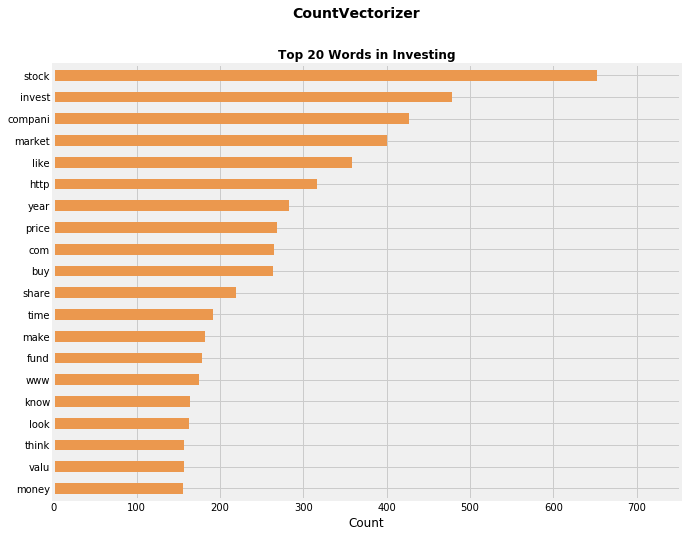

In [34]:
jer = barplot_with_cvec(df1,'subreddit','investing','final_posts','Top 20 Words in Investing',\
                  'CountVectorizer','#EB984E')


['market',
 'stock',
 'use',
 'day',
 'like',
 'time',
 'trader',
 'make',
 'look',
 'want',
 'buy',
 'start',
 'profit',
 'share',
 'account',
 'option',
 'posit',
 'sell',
 'broker',
 'thank']

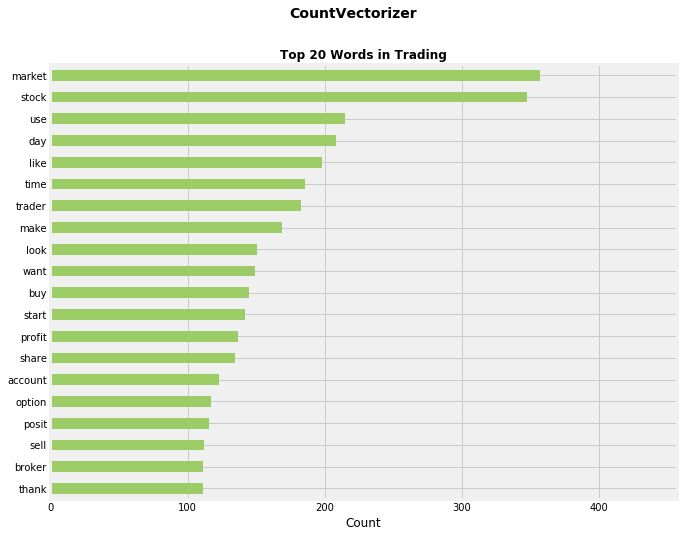

In [85]:
barplot_with_cvec(df1,'subreddit','Trading','final_posts','Top 20 Words in Trading',\
                  'CountVectorizer','#9CCC65')

# Barplots, using TF-IDF Vectorizer for Investing and Trading respectively 

#### Findings 
- as seen from the chart, words like http, com , are present in both individual reddits.
- Investing subreddit
        - http count is in the 10ish range
         - com count is in the 10ish range
        
- Trading subreddit
        - http count is in the 10ish range
        - com count is NIL 

In [36]:
#Writing a function for barplot for each subreddit, investing , trading

def barplot_with_tvec(df,colname, coltype,groupby,title,suptitle, color):
    words_series = df[df[colname]==coltype][groupby] #masking
   
    # Instantiate CountVectorizer 
    tvec = TfidfVectorizer(stop_words='english')
    
    # Fitting
    tvec_df = pd.DataFrame(tvec.fit_transform(words_series).toarray(), columns=tvec.get_feature_names())

    
    #Plot Properties
    tvec_df = tvec_df.sum(axis=0) # Sum up the no. of occurences for each word
    tvec_df = tvec_df.sort_values(ascending=False).head(20)
    tvec_df.sort_values(ascending=True).plot(kind='barh', figsize=(10,8), color=color)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Count', fontsize=12)
    plt.xlim(0,max(tvec_df)) 
    plt.suptitle(suptitle,fontsize=14,fontweight="bold")

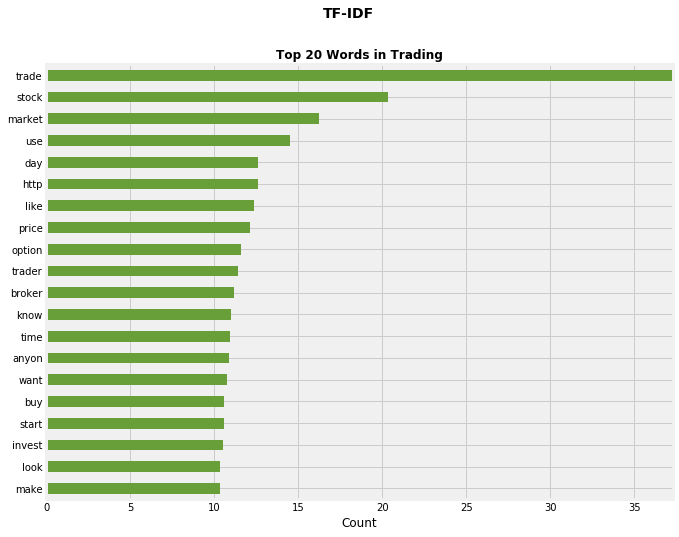

In [37]:
barplot_with_tvec(df1,'subreddit','Trading','final_posts','Top 20 Words in Trading','TF-IDF','#689F38')

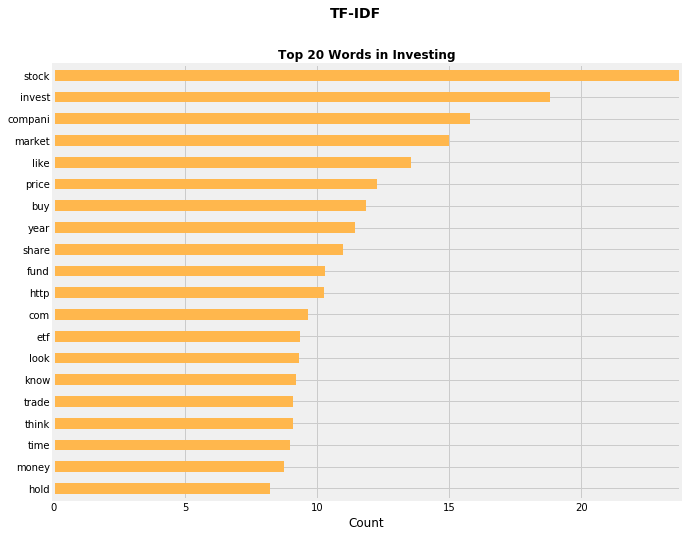

In [38]:
barplot_with_tvec(df1,'subreddit','investing','final_posts','Top 20 Words in Investing','TF-IDF','#FFB74D')

## Post EDA Analysis - Adjustments to be made 

- Removing more stopwords , common words in both investing and trading, such as, price, know , money, which is common words that dont mean anything. 
- Will also remove words like invest and trade, as they are the stemmed word of Investing and Trading, also , these words are removed so we can see what other better words can represent these 2 subreddit.

- this will be done by adding more stopwords via cleaner2 function 

- adjustment for train test split


Adjusting for more stopwords to be included 

In [39]:
def cleaner2(final_posts):
    stopwords2 = ['http','com','www','price','know','money','invest','trade']
    words = final_posts.lower().split()
    cleanser = [x for x in words if x not in stopwords2]
    return(" ".join(cleanser))


In [40]:
df1['final_posts'] = df1['final_posts'].map(cleaner2)

In [41]:
X = df1['final_posts']
y = df1['class']

# Modelling

- Step 1 : Find Baseline Model i.e. how many percentage of the posts are currently Investing and Trading
- Step 2 : Train / Test split with stratify
- Model 1 : Logistic Regresion on Count Vectorizer + Logistic Regression TVIDF with GridSearch
    - Why Logistic Regression, because we have alreaddy classified as Invest or Not Investing(i.e. Trading)
- Model 2 : Naive Bayes on Count Vectorizer  + Naive Bayes on Count Vectorizer with Grid Search

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [43]:
X_train.shape

(868,)

In [44]:
X_test.shape

(217,)

In [45]:
y_train.value_counts(normalize = True)

1    0.516129
0    0.483871
Name: class, dtype: float64

In [46]:
y_test.value_counts(normalize = True)

1    0.516129
0    0.483871
Name: class, dtype: float64

| Train dataset | Test/Validation dataset |
| -- | -- |
| 48.39% is Investing posts  | 48.39% is Investing posts |
| 51.61% is Trading posts | 51.61% is Trading posts |

# 2 by 2 Models Preparation

- 2 types of Feature Selection, CountVectorizer (CVEC) and TF-IDF (TVEC)
- CVEC will take take non-duplicated words as its vocabulary a.k.a the feature 
- TVEC will will penalise words that appear if appear in many posts, hence we get words that are more significant 


- 2 types of clasfication model, Logistic Regression (LR) and Naive Bayes (NB)
- Logistic Regression will be a binary classfication model in this study, as it will be Investing = 0 or not Investing = 1 = Trading 
- Naive Bayes: Multinominal is selected , because each feature/vocabulary, can take a continuous variable, for example, the feature, stock, can have a total count of 1000, hence cannot use Bernouli. Unable to use Gaussian is because the values are not normally distributed, because each post is written differently, hence the count values for each vocabulary is not normlly distributed. 


## Model 1 : Logistic Regression with CountVectorizer 

In [47]:
# Create a pipeline with CountVectorizer and LogisticRegression
pipe1 = Pipeline([
                    ('cvec', CountVectorizer(stop_words='english')),
                    ('lr', LogisticRegression(random_state=42,solver='liblinear'))
                ])

# Search over the following values of hyperparameters:
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Logistic regression penalty: l2 - Ridge
# Inverse of regularization strength: 0.01,0.1
pipe1_params = {
                'cvec__max_features': [1000,2000,3000,4000,5000],
                'cvec__min_df': [2,3], 
                'cvec__max_df': [.85,.9,.95],
                'cvec__ngram_range': [(1,1), (1,2)],
                'lr__penalty': ['l1','l2'],
                'lr__C': [.01,.1,1,10]
                }

# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe1, # Objects to optimise
                          param_grid = pipe1_params, # Hyperparameters for tuning
                          cv=5) # 5-fold cross validation

# Fit GridSearch to training data
gs_cvec_lr.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [48]:
print('Best score: ', gs_cvec_lr.best_score_)
print('Training score:', gs_cvec_lr.score(X_train, y_train))
print('Test score:', gs_cvec_lr.score(X_test, y_test))

Best score:  0.7971629792040396
Training score: 0.9827188940092166
Test score: 0.8248847926267281


##### TF-IDF 

In [49]:
# Create a pipeline with TF-IDF and LogisticRegression
pipe2 = Pipeline([
                    ('tvec', TfidfVectorizer(stop_words='english')),
                    ('lr', LogisticRegression(random_state=42,solver='liblinear'))
                ])

# Search over the following values of hyperparameters:
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Logistic regression penalty: l2 - Ridge
# Inverse of regularization strength: 0.01,0.1
pipe2_params = {
                'tvec__max_features': [1000,2000,3000,4000,5000],
                'tvec__min_df': [2,3], 
                'tvec__max_df': [.85,.9,.95],
                'tvec__ngram_range': [(1,1), (1,2)],
                'lr__penalty': ['l1','l2'],
                'lr__C': [.01,.1,1,10]
            }

# Instantiate GridSearchCV
gs_tvec_lr = GridSearchCV(pipe2, # Objects to optimise
                          param_grid = pipe2_params, # Hyperparameters for tuning
                          cv=5) # 5-fold cross validation

# Fit GridSearch to training data
gs_tvec_lr.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [50]:
print('Best score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Test score:', gs_tvec_lr.score(X_test, y_test))

Best score:  0.809793369211348
Training score: 0.9089861751152074
Test score: 0.783410138248848


### Naive Bayes MultinomialNB 

##### Count Vectorizer

In [51]:
# Create a pipeline with CountVectorizer and Naive Bayes
pipe3 = Pipeline([
                    ('cvec', CountVectorizer(stop_words='english')),
                    ('nb', MultinomialNB())
                ])

# Search over the following values of hyperparameters:
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
pipe3_params = {
                'cvec__max_features': [1000,2000,3000,4000,5000],
                'cvec__min_df': [2,3], 
                'cvec__max_df': [.85,.9,.95], 
                'cvec__ngram_range': [(1,1), (1,2)]
                }

# Instantiate GridSearchCV
gs_cvec_nb = GridSearchCV(pipe3, # Objects to optimise
                          param_grid = pipe3_params, # Hyperparameters for tuning
                          cv=5) # 5-fold cross validation

# Fit GridSearch to training data
gs_cvec_nb.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [52]:
print('Best score: ', gs_cvec_nb.best_score_)
print('Training score:', gs_cvec_nb.score(X_train, y_train))
print('Test score:', gs_cvec_nb.score(X_test, y_test))

Best score:  0.8040595309281775
Training score: 0.881336405529954
Test score: 0.7695852534562212


##### TF-IDF 

In [53]:
# Create a pipeline with TF-IDF and Naive Bayes
pipe4 = Pipeline([
                    ('tvec', TfidfVectorizer(stop_words='english')),
                    ('nb', MultinomialNB())
                ])

# Search over the following values of hyperparameters:
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
pipe4_params = {
                'tvec__max_features': [1000,2000,3000,4000,5000],
                'tvec__min_df': [2,3], 
                'tvec__max_df': [.85,.9,.95], 
                'tvec__ngram_range': [(1,1), (1,2)]
                }

# Instantiate GridSearchCV
gs_tvec_nb = GridSearchCV(pipe4, # Objects to optimise
                          param_grid = pipe4_params, # Hyperparameters for tuning
                          cv=5) # 5-fold cross validation

# Fit GridSearch to training data
gs_tvec_nb.fit(X_train,y_train)




GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [54]:
print('Best score: ', gs_tvec_nb.best_score_)
print('Training score:', gs_tvec_nb.score(X_train, y_train))
print('Test score:', gs_tvec_nb.score(X_test, y_test))

Best score:  0.8086572320776029
Training score: 0.9009216589861752
Test score: 0.7511520737327189


## Summary of models performance

- All the models are underperforming on test data. The reason is because Grid Search gets the best performing model on the train set, hence when applied on test set data, it will under perform.
- Logistic Regression models tend to achieve a 0.90 score at least on train data, as compared to Naive Bayes models only 0.88 score. 

- For LR + CVEC it achieved 0.983 on train and 0.825 on test data, the differential is 0.158 
- For LR + TV-IDF it achieved 0.909 on train and 0.783 on test data, the differential is 0.126
- For Naive Bayes + CVEC it achieved 0.881 and 0.770 on test data, the differential is 0.111
- For Naive Bayes + TF-IDF it achieved 0.901 and 0.751 on test data, the differential is 0.150
- The clear winner out of the underperforming model is Naive Bayes + CVEC as the train and test score are closer to each other.

looking at the coefficent of the model 

|       | Logistic + CVEC  | Logistic + TV-IDF | Naive Bayes + CVEC  | Naive Bayes + TF-IDF |
|-------|------------------|-------------------|---------------------|----------------------|
| Train | 0.983            | 0.909             | 0.881               | 0.901                |
| Test  | 0.825            | 0.783             | 0.770               | 0.751                |


#  Model fit with Naive Bayes + CVEC 

In [55]:
gs_cvec_nb.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [56]:
final_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(max_df= 0.85,
     max_features= 2000,
     min_df= 2,
     ngram_range= (1, 1))),
    ('nb',MultinomialNB())
])

In [57]:
final_cvec_nb.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.85,
                                 max_features=2000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('nb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [58]:
pred = final_cvec_nb.predict(X_test)

In [59]:
# Making a dataframe with test data, which contains final_pposts, actual class value, predicted class value, and predict probability

results = pd.DataFrame(X_test, columns=['final_posts']) # making a dataframe on one column known as final_posts
results['actual'] = y_test# add 'actual' colun
results['predictions'] = pred
results['predict_proba'] = [i[1] for i in final_cvec_nb.predict_proba(X_test)]
results.shape

(217, 4)

# Model Evaluation - Performance Metrics
## Accuracy, Sensitivity, Specificity, Precision and AUC ROC
Performance Parameters

- Negative = investing = 0
- Positive = not investing / trading = 1 
- True positive = 91 posts that is trading, and predicted as trading 
- True negative = 76 posts that is investing , and predicted as investing
- False positive = 29 posts that is investing , predicted as trading 
- False negative = 21 posts that is trading, predicted as investing

- Type I error = False Positive = 29 posts
- Type II error = False Negative = 21 posts 

Type I or Type II error - which is worse ? 
- As a post is being misclassfieid as investing instead of trading, or vice versa, it does not have a 'worse-off' in being in either Type I or Type II, hence unable to explain which error is worse. 



Performance Metrics 

- Accuracy of 0.77 = The model predicted 77% of test data correct to its respective Investing and Trading subreddit, as accuracy calculates the True Positive posts which is trading and the True Negative posts which are Investing. 

- Misclassification rate of 0.23 = 23% of the posts were classified, i.e. supposedly Investing subreddit, went to Trading subreddit, vice versa. This is also calculated as 100 % - ( accurac of 77%  , which will gives 23% 

- Sensitivity of 0.81 aka True Positive Rate aka Recall = True Positives divided by Positives, i.e. the classified correctly Trading posts divided by ( trading posts that were predicted correctly and belong to trading posts + investing posts that were predicted as trading ) 

- Specificity of 0.724 aka True Negative Rate =  True Negatives divided by All Negatives, i.e. posts that were predicted as Investing and belong to Investing subreddit, divided by all investing posts, including those that were trading but predicted as investing posts. 

- Precision of 0.758 aka Positive Predictive Value = True Positives / ( True Positive + False Positives ) = Posts that are trading predicted as trading / all trading posts 

- ROC AUC score is 0.823, which means my 0 and 1 populations are close to perfect separation/distinction, a score 1 is the best, i.e. the Naive Bayes model is able to predict perfectly where the post should be in which subreddit. 

In [60]:
# Evaluation Metrics formulas, unpacking it and caluclating it 
tn, fp, fn, tp = confusion_matrix(y_test,
                                  pred).ravel()

accuracy = round ( (tp+tn)/(tp+fp+tn+fn),3)
misclassification = round((fp+fn)/(tp+fn+fp+tn),3)
sensitivity= round(tp/(tp+fn),3)
specificity = round(tn/(tn+fp),3)
precision = round (tp/(tp+fp),3 )
print(f"Accuracy: {accuracy}")
print(f"Misclassification Rate: {misclassification}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")


Accuracy: 0.77
Misclassification Rate: 0.23
Sensitivity: 0.812
Specificity: 0.724
Precision: 0.758


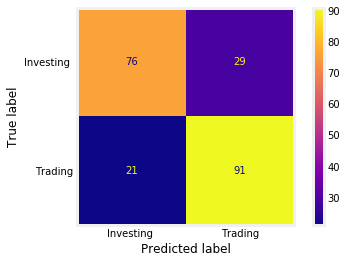

In [61]:
# Plot for confusion matrix 
plot_confusion_matrix(final_cvec_nb, X_test, y_test,
                      values_format = 'd',
                      display_labels = ["Investing ","Trading"],
                      cmap='plasma')

plt.grid(False)
plt.show()

In [62]:
#Retrieve roc_auc_score for plotting 
roc_auc_score(results['actual'], results['predict_proba'] )

0.8266156462585034

<Figure size 720x360 with 0 Axes>

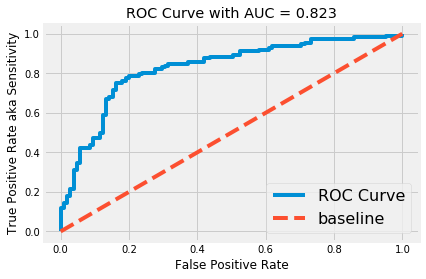

In [63]:
#plotting ROC curve with the roc auc score
plt.figure(figsize = (10,5))
plot_roc_curve(final_cvec_nb, X_test, y_test, label = 'ROC Curve');
plt.ylabel('True Positive Rate aka Sensitivity')
plt.xlabel('False Positive Rate');

plt.title(f'ROC Curve with AUC = 0.823')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 10),
         np.linspace(0, 1, 10),
         label='baseline',
         linestyle='--')
plt.legend(fontsize=16);

# Words Identification from NB Model Fit 

### Coefficients and predictive words

Naive bayes model analyse words from train data, and gives each word a score to predict the positive class. 
The higher the weightage, the more likely the words points towards the positive class. 
In this case, the positvie class = 1 which is equals to Trading 
The negative class = 0 , which is equals to Investing. 


The larger the coefficient, the higher the score are the words that can be used to predict it is in trading subreddit. 



the disadvantage of naive bayes, is that it takes each feature/vocab independently, its assumption holds for its processing, i.e. to say if a word appear 4 time, it will give it a better score, which is a good thing in a gneral sense, cause it can be used in multi-languages, and it will not hold any significance to other word. 

But the disadavantage is if let says the word is not present in the other classifier group, it susdenly becomes dropped off. 



###  Predictive Words for Positive Class / Trading Subreddit

Larger Coefficients = Positive Class = Trading

Predictive Words identified for Trading subreddit


| ['thank', 'anyon', 'broker', 'posit', 'sell', 'account', 'profit',
       'start', 'share', 'buy', 'want', 'look', 'make', 'trader', 'time',
       'day', 'like', 'use', 'stock', 'market'] |

Smallest Coefficient = Negative Class = Investing 

Predictive Words identified for Investing subreddit 

| ['stock', 'compani', 'market', 'like', 'year', 'buy', 'share',
       'time', 'make', 'fund', 'look', 'sell', 'think', 'investor',
       'rate', 'valu', 'long', 'term', 'return', 'good'] |

In [64]:
#prob for positive class
pos_class_prob_sorted = gs_cvec_nb.best_estimator_.named_steps['nb'].feature_log_prob_[1].argsort()[::-1]
#prob for negative class
neg_class_prob_sorted = gs_cvec_nb.best_estimator_.named_steps['nb'].feature_log_prob_[0].argsort()[::-1]
#getting the top features 
neg_top_features = np.take(gs_cvec_nb.best_estimator_.named_steps['cvec'].get_feature_names(), neg_class_prob_sorted)
pos_top_features = np.take(gs_cvec_nb.best_estimator_.named_steps['cvec'].get_feature_names(), pos_class_prob_sorted)

In [65]:
pos_top_features[0:20]

array(['market', 'stock', 'use', 'like', 'day', 'time', 'trader', 'make',
       'look', 'want', 'buy', 'share', 'start', 'profit', 'account',
       'sell', 'posit', 'broker', 'anyon', 'thank'], dtype='<U15')

In [66]:
neg_top_features[0:20]

array(['stock', 'compani', 'market', 'like', 'year', 'buy', 'share',
       'time', 'make', 'fund', 'look', 'sell', 'think', 'investor',
       'rate', 'valu', 'long', 'term', 'return', 'good'], dtype='<U15')

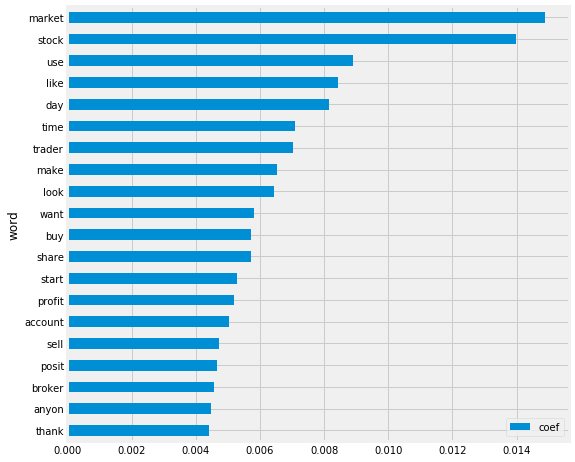

In [67]:
# Save the words obtained from TF-IDF Naive Bayes in a dataframe
coef_df = pd.DataFrame(gs_cvec_nb.best_estimator_.named_steps['cvec'].get_feature_names(), columns=['word'])
# Save the coefficients in the same dataframe
coef_df['coef'] = np.exp(gs_cvec_nb.best_estimator_.named_steps['nb'].coef_.tolist()[0])
# Find the top 20 predictive words
coef_df.sort_values('coef').tail(20).plot(y='coef', x='word', kind='barh', figsize=(8,8));

###  Top 20 words in misclassified posts ( Investing predicted as Trading ) 

Lets take a look at the words in posts that were predicted at Trading subreddit and why ? 

| 
['stock',
 'like',
 'use',
 'month',
 'risk',
 'buy',
 'option',
 'thank',
 'start',
 'make',
 'time',
 'broker',
 'anyon',
 'market',
 'look',
 'inform',
 'question',
 'xrp',
 'need',
 'day'] |

In [68]:
# making a dataframe that only show misclassified posts, i.e actual post and prediction post are not the same classified
wrong_pred = results[ results['actual'] != results['predictions']] 
wrong_pred.shape

(50, 4)

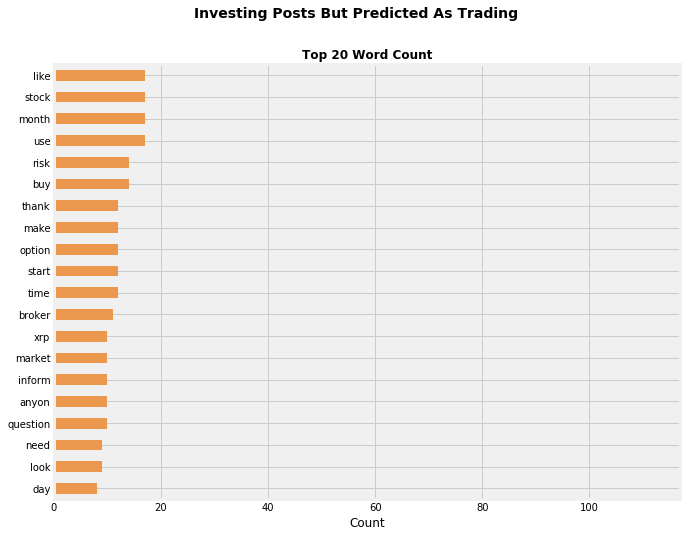

In [69]:
# barplot for Investing Posts predicted as Trading
jer = barplot_with_cvec(wrong_pred,'actual',0,'final_posts','Top 20 Word Count',
                        'Investing Posts But Predicted As Trading','#EB984E')



In [70]:
jer

['like',
 'stock',
 'month',
 'use',
 'risk',
 'buy',
 'make',
 'option',
 'thank',
 'start',
 'time',
 'broker',
 'xrp',
 'market',
 'inform',
 'anyon',
 'question',
 'look',
 'need',
 'day']

###  Top 20 words in misclassified posts ( Trading predicted as Investing ) 

Lets take a look at the words that were predicting as Investing subreddit and why ? 

| ['million',
 'market',
 'gold',
 'stock',
 'hydrogen',
 'electr',
 'percent',
 'vehicl',
 'increas',
 'dollar',
 'sale',
 'time',
 'year',
 'sinc',
 'expect',
 'mani',
 'economi',
 'like',
 'unemploy',
 'tourism'] |

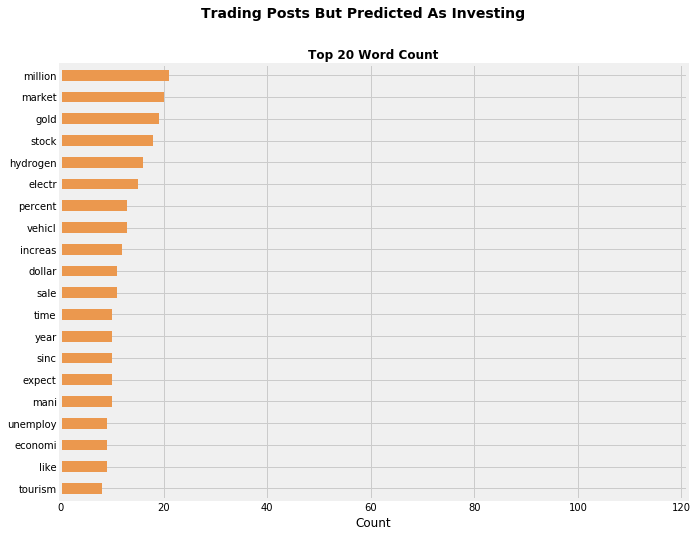

In [84]:
#barplot for Trading Posts predicted as Investing 
jer = barplot_with_cvec(wrong_pred,'actual',1,'final_posts','Top 20 Word Count',
                        'Trading Posts But Predicted As Investing','#EB984E')


In [72]:
jer

['million',
 'market',
 'gold',
 'stock',
 'hydrogen',
 'electr',
 'percent',
 'vehicl',
 'increas',
 'dollar',
 'sale',
 'time',
 'year',
 'sinc',
 'expect',
 'mani',
 'economi',
 'like',
 'unemploy',
 'tourism']

# Summary
- Analysis @ individual words 
- Analysis @ misclassified posts 

Purpose of analysis at individualistic words and post. 

When we analyse the words, we look at the trend of the words occuring and determine the subreddit.

However, when we analyse the post in depth, we understand the context of the post. This way we can further understand if our model predicting wrongly, or did the owner of the post actually did post wrongly ? 




### Analysis @ Words 

Look below for workings 

- Trade Pred Words = Words that our Naive Bayes model has selected that it will predict the post belong to Trading Subreddit

- Invest Pred Words = Words that our Naive Bayes models has selected that it will predict the post belong to Investing Subreddit 

- Misclass as trad = Top 20 Words from misclassified post

- Misclass as invest = Top 20 Words from misclassified post

If we look at the words "stock", "like" and "market", they are both predictive words for Trading and Investing subreddit, hence this results to them being misclassfieid. This is further proven by these 2 words being present in the Misclass as trad , and misclass as invest columns 

Post-Model-Fit Observed Failure #1 : words that are frequently in both reddit should have been added to stopwords, as now it causes an issue where the model is unable to predict properly. 

Another observation to study is, posts wrongly misclassified as Investing, are those words present as predictive words for investing, because such words are worthy to explore further. For example, words like "hydrogen", "unemploy", "sale" that are not the predictive words from the invest pred words. 

Same applies for posts wrongly misclassfieid as Trading, are they present as predictive words for trading .


This could be due to several reasons 
1) our test data is too small, i.e. with more posts size, we might actually able to capture it, just that in this sample test size, it is not present. 
2) the coefficients of the top 20 for predicting the positive and negative class were captured, i.e. to say it could be the word "hydrogen" could be in the 25th coefficient. 



In [83]:
# setting the variables/column list values 
trad_pred_words = ['market', 'stock', 'use', 'like', 'day', 'time', 'trader', 'make',
       'look', 'want', 'buy', 'share', 'start', 'profit', 'account',
       'sell', 'posit', 'broker', 'anyon', 'thank']
invest_pred_words = ['stock', 'compani', 'market', 'like', 'year', 'buy', 'share',
       'time', 'make', 'fund', 'look', 'sell', 'think', 'investor',
       'rate', 'valu', 'long', 'term', 'return', 'good']

misclass_as_trad = ['like', 'stock', 'month', 'use', 'risk', 'buy', 'make', 'option', 'thank',
 'start', 'time', 'broker', 'xrp', 'market', 'inform', 'anyon', 'question', 'look', 'need',
 'day']

misclass_as_invest = ['million', 'market', 'gold', 'stock', 'hydrogen', 'electr', 'percent',
 'vehicl', 'increas', 'dollar', 'sale', 'time', 'year', 'sinc', 'expect', 'mani', 'economi',
 'like', 'unemploy', 'tourism']

In [82]:
# putting the main words in a dataframe
words_df1 = pd.DataFrame ( list (zip (trad_pred_words, invest_pred_words,
                                      misclass_as_trad, misclass_as_invest)) ,
                          columns = ["Trade Pred Words","Invest Pred Words",
                                     "misclass_as_trad","misclass_as_invest"] )

In [75]:
words_df1

,Trade Pred Words,Invest Pred Words,misclass_as_trad,misclass_as_invest
0,market,stock,like,million
1,stock,compani,stock,market
2,use,market,month,gold
3,like,like,use,stock
4,day,year,risk,hydrogen
5,time,buy,buy,electr
6,trader,share,make,percent
7,make,time,option,vehicl
8,look,make,thank,increas
9,want,fund,start,dollar


### Analysis On Misclassified Posts


In [76]:
wrong_pred.head(10)

,final_posts,actual,predictions,predict_proba
214,bid ask spread across broker beginn question thing equal bid ask spread across broker point time secur etc sell differ market maker use differ broker shop lowest bid ask spread use differ broker,0,1,1.000000e+00
309,tesla order cancel full disclosur total noob friday put limit order share tesla reason idea chaotic go monday want autom purchas much possibl shit hit fan woke morn surpris order went threw alread...,0,1,1.000000e+00
419,googl show everi stock us dollar recent start buy stock stuck tsx market time time would whip phone search googl specif stock googl return would show instant currenc exchang market stock regist to...,0,1,7.400721e-01
607,tsla call warrant question tesla call warrant respond well moon stock call option basic theori miss,1,0,3.557933e-02
34,hi guy noob doea mean red arrow next stock hi guy log rh arrow red next fraction share postion also look wrong lower yesterday anyon mayb rh system issu thank yolololol,0,1,9.999388e-01
241,everyon run wheel save fairli new option start learn spring progress summer learn mani thing mostli use conserv strategi like iron condor credit spread gener low risk passiv incom even though arou...,0,1,8.789091e-01
725,intel amd tomorrow earn intel amd bounc away intel tank seem like overreact curiou guy think happen bell ring tomorrow also buy overreact criteria get stock also way around determin short bump new...,1,0,2.003830e-03
820,alredi bought tsla chines help earn shpuld consid enemi thetrad stock tesla tsla catch chines electr vehicl market increas share sold model thetrad stock tesla tsla catch chines electr vehicl mark...,1,0,1.005049e-09
207,option portfolio risk manag strategi blindspot goal reduc complet ruin probabl one portfolio turnov alpha sourc backtest small live test winrat slightli reward risk optim kelli bet size w w rr how...,0,1,9.999900e-01
797,sinc everyth trump move market learn sdni public corrupt unit handl charg ghislain maxwel normal type charg handl violent organ crime unit due natur tell us credibl evid publicli elect offici invo...,1,0,2.370772e-04


In [81]:
# Locating posts that is investing but predicted as trading
df1.loc[34]['total']

"Hi guys noob here....what doea it mean when there is a red arrow next to the stock's price? Hi guys I just logged into my RH and there are all these down arrows in red next to the prices of my fractional share postions.  Also, the prices look wrong because they are lower than yesterday.  Does anyone know if maybe RH is having system issues?  Thanks and YOLOLOLOL"

In [80]:
# Locating posts that is trading but predicted as investing
df1.loc[797]['total']

'Since everything Trump moves the market. I’ve learned that the SDNY Public Corruption unit is handling the charges for Ghislaine Maxwell. Normally this type of charge with be handle by the Violent Organized Crime unit due to the nature. What that tells us is that they have credible evidence that a publicly elected official is involved. We’ve all seen many many photos of Trump with Epstein. Is it at all possible that it’s Trump?!?!?!  She is currently in negotiations for a cooperative plea bargain so the cats are coming out of the bag and they fat. Think I’m busing some puts'

# Conclusion 

- Through our model, we managed to study the predicative words of what the Investing and Trading subreddit is about
- By using the world most active discussion board, we managed to get a 'global' interpretation of what everyone feels Investing and Trading actually is.

From the findings of the Naive Bayes + CVEC model ,global interpretation for Investing suggests that people are looking to do long term investments or funds, holding/buying companies, and most importantly looking at value of the company. 

Whilst for the global interpration for Trading, it suggests people are looking to day trade, discussing about brokers, probably to find the lowest commission platforms, and mostly asking questions , as there is a high word count of Thank. 


### Recommendation(s):

__Redefining Description__
#1 : Moderators can re-define  the description of each subreddit, so that posters have a sense of which subreddit to enter, this would __improve user experience and readers/authors know the differences of the two subreddits.__

__Subreddit Merger__ 
#2 : Although I might not have included the common predictive words for both subreddits, it also suggests another point of view, if there is so much similarity, could the two subreddit be combined as 1 subreddit ? 
Investing subreddit has 1.20 million members, Trading has 0.03 million members

__Auto Subreddit Classifier__
#3 With this model, it is able to identify 77% of the posts accurately, reddit could deploy this model to 'force' authors to select the proper subreddit, i.e. after the author types his/her post, if the models predicts it belongs to Investing, authors have no other options but to post to Investing

### Limitation(s):

#1 : __Common Predictive Words__


Predictive words that are present in predicting it is a Trading or Investing subreddit, could have been further included in the stopwords. This would allow better features being selected, which could lead to a better prediction model. 



#2 : __Sample Size__

The train dataset studied on 868 posts , whilst the test dataset only has 217. The test sample size might be too small, and some of these posts could be mostly __hyperlink sharing, which does not tell much about the post.__

#3 : __Coefficients 20__ 

As the coefficients captured are only the top 20, some posts could not be understood as the posts might be only having the coefficients of rank 40 or rank 50 onwards. 